In [1]:
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image


import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

In [12]:
data_file_path = 'C:/Users/unnat/Desktop'
image_path = []
labels = []
folds = os.listdir(data_file_path)
for fold in folds:
    try:
        fold_path = os.path.join(data_file_path,fold)
        flist = os.listdir(fold_path)
    except Exception as e:
        continue
    for f in flist:
        try:
            f_path = os.path.join(fold_path, f)
            filelist = os.listdir(f_path)
        except Exception as e:
            continue
        
        for file in filelist:
            fpath = os.path.join(f_path, file)
            image_path.append(fpath)

            if f == 'colon_aca':
                labels.append('Colon Adenocarcinoma')

            elif f == 'colon_n':
                labels.append('Colon Benign Tissue')

            elif f == 'lung_aca':
                labels.append('Lung Adenocarcinoma')

            elif f == 'lung_n':
                labels.append('Lung Benign Tissue')

            elif f == 'lung_scc':
                labels.append('Lung Squamous Cell Carcinoma')
                
Fseries = pd.Series(image_path, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis= 1)

In [13]:
df

,filepaths,labels
0,C:/Users/unnat/Desktop\mysql-8.0.31-winx64\mys...,Colon Adenocarcinoma
1,C:/Users/unnat/Desktop\mysql-8.0.31-winx64\mys...,Colon Adenocarcinoma
2,C:/Users/unnat/Desktop\mysql-8.0.31-winx64\mys...,Colon Adenocarcinoma
3,C:/Users/unnat/Desktop\mysql-8.0.31-winx64\mys...,Colon Adenocarcinoma
4,C:/Users/unnat/Desktop\mysql-8.0.31-winx64\mys...,Colon Adenocarcinoma
...,...,...
25002,C:/Users/unnat/Desktop\New_folder\lung_scc\lun...,NaN
25003,C:/Users/unnat/Desktop\New_folder\lung_scc\lun...,NaN
25004,C:/Users/unnat/Desktop\New_folder\lung_scc\lun...,NaN
25005,C:/Users/unnat/Desktop\New_folder\lung_scc\lun...,NaN


#### Load Data for Image Processing

In [14]:
df['labels'].value_counts()

Colon Adenocarcinoma            5000
Colon Benign Tissue             5000
Lung Adenocarcinoma             5000
Lung Benign Tissue              5000
Lung Squamous Cell Carcinoma    5000
Name: labels, dtype: int64

In [15]:
df=df.dropna()

In [16]:
strat = df['labels']
train_df, dummy_df = train_test_split(df,  train_size= 0.7, shuffle= True, random_state= 123, stratify= strat)

# valid and test dataframe
strat = dummy_df['labels']
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.5, shuffle= True, random_state= 123, stratify= strat)

In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Cropped image size
batch_size = 64
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

# ImageDataGenerator with data augmentation
tr_gen = ImageDataGenerator(
    rescale=1./255,  # Normalization
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

# ImageDataGenerator for validation and testing without data augmentation
ts_gen = ImageDataGenerator(rescale=1./255)  # Normalization

# Flow from DataFrame with data augmentation for training
train_gen = tr_gen.flow_from_dataframe(
    train_df,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size
)

# Flow from DataFrame for validation without data augmentation
valid_gen = ts_gen.flow_from_dataframe(
    valid_df,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size
)

# Flow from DataFrame for testing without data augmentation
test_gen = ts_gen.flow_from_dataframe(
    test_df,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False,
    batch_size=batch_size
)

Found 17495 validated image filenames belonging to 5 classes.
Found 3749 validated image filenames belonging to 5 classes.
Found 3749 validated image filenames belonging to 5 classes.


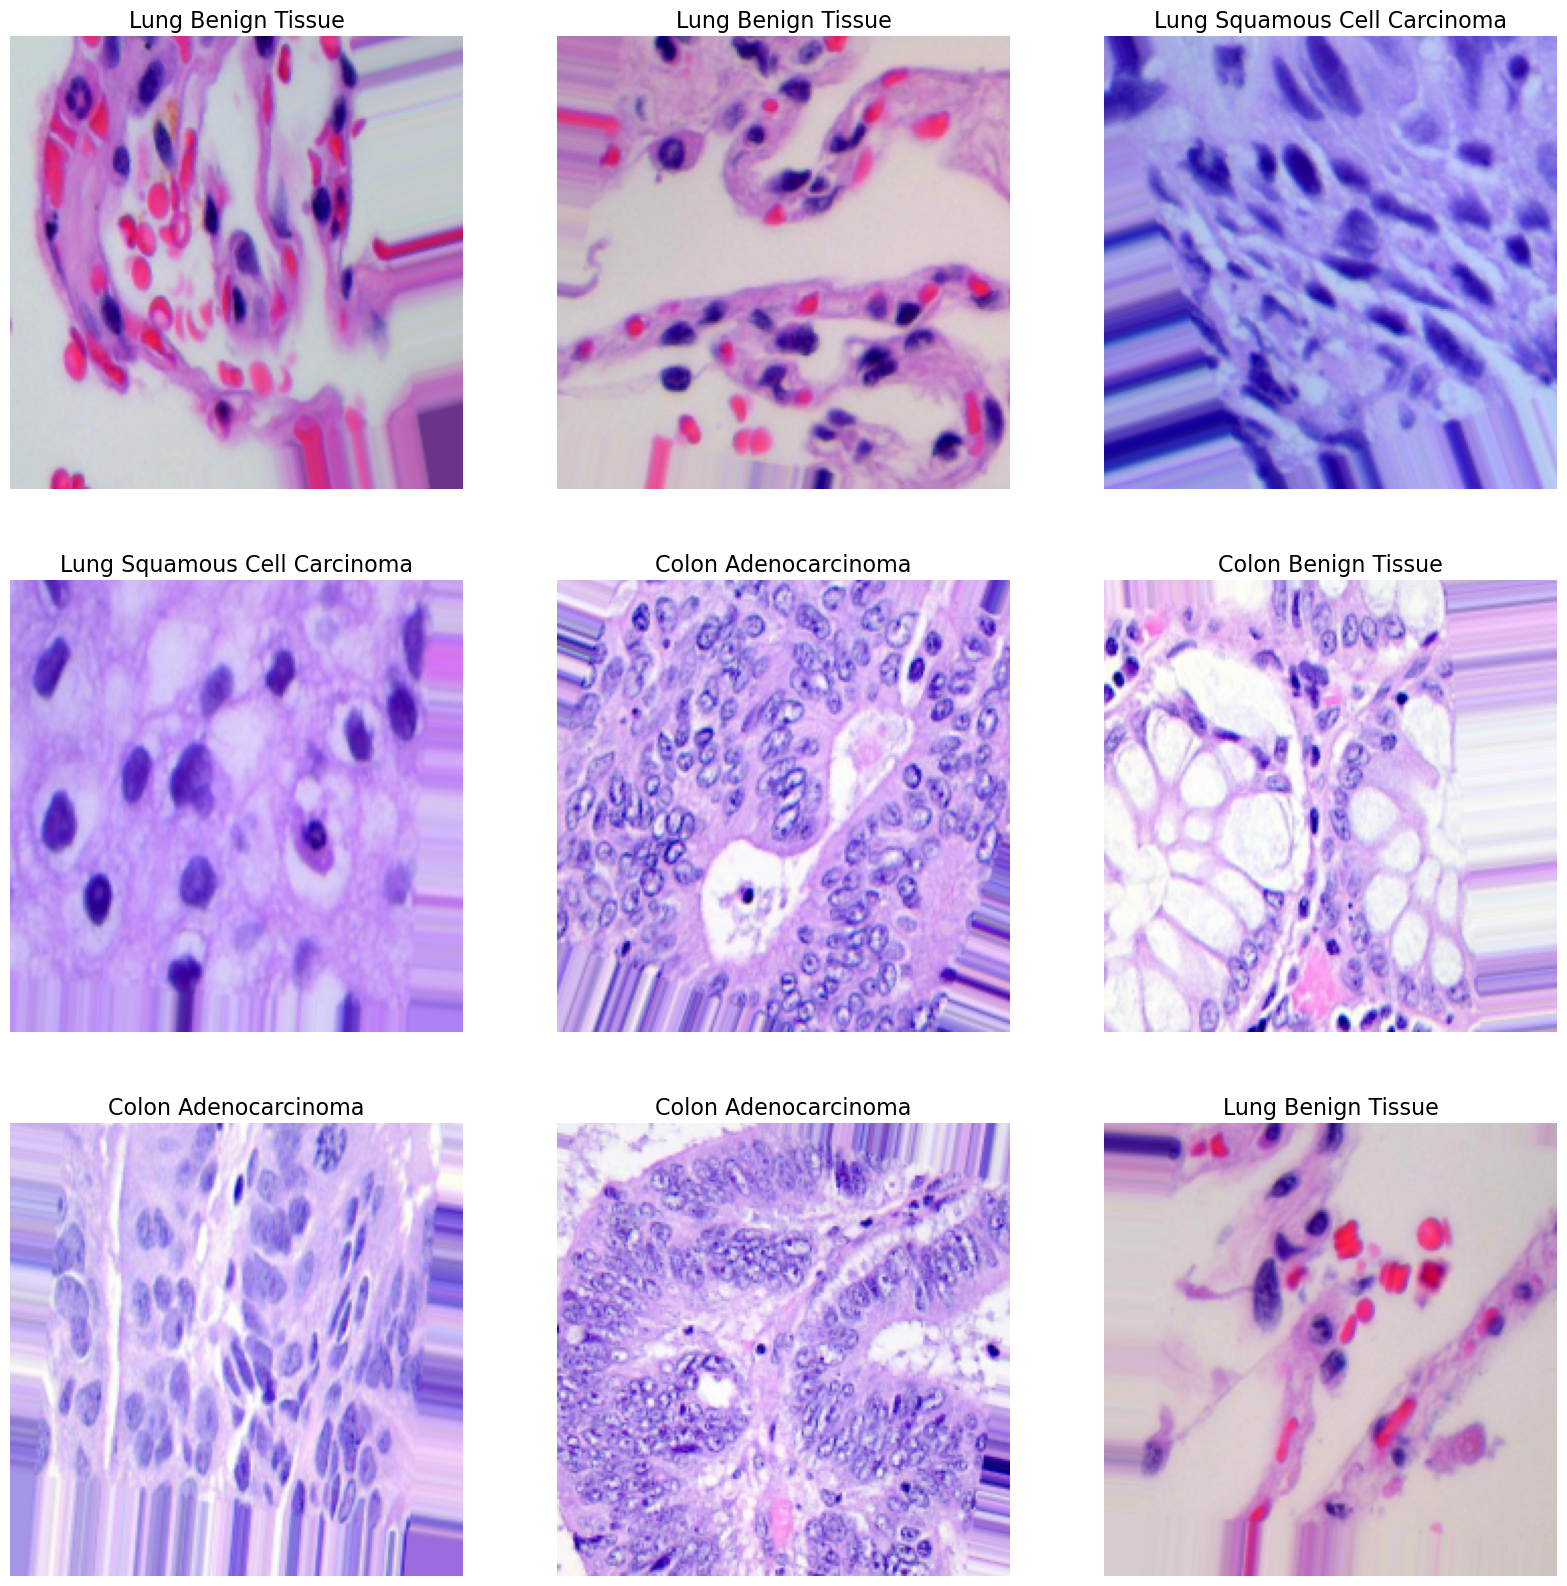

In [18]:
g_dict = train_gen.class_indices      
classes = list(g_dict.keys())       
images, labels = next(train_gen)

# Display the first few images in the batch
plt.figure(figsize=(20, 20))
for i in range(min(9, batch_size)):  # Display up to 9 images
    plt.subplot(3, 3, i + 1)
    index = np.argmax(labels[i])
    plt.imshow(images[i])
    plt.title(classes[index],fontdict={'fontsize': 16})
    plt.axis("off")
    

plt.show()

In [22]:
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.models import Model

# ResNet101
Image_Size=[224,224]

resnet=Sequential()

resnet.add(ResNet101(input_shape=Image_Size+[3],weights='imagenet',include_top=False,pooling='average'))

# This is to ensure the base won't be trained again
for layer in resnet.layers:
    layer.trainable=False

flatten=Flatten()(resnet.output)
dense=Dense(256,activation='relu')(flatten)
dense=Dense(128,activation='relu')(dense)
dense=Dropout(0.2)(dense)   # We add a dropout here to prevent overfitting
prediction=Dense(5,activation='softmax')(dense)

resmodel=Model(inputs=resnet.input,outputs=prediction)

resmodel.summary()

resmodel.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet101_input (InputLaye  [(None, 224, 224, 3)]     0         
 r)                                                              
                                                                 
 resnet101 (Functional)      (None, 7, 7, 2048)        42658176  
                                                                 
 flatten_2 (Flatten)         (None, 100352)            0         
                                                                 
 dense_6 (Dense)             (None, 256)               25690368  
                                                                 
 dense_7 (Dense)             (None, 128)               32896     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                           

In [24]:
from tensorflow.keras.callbacks import EarlyStopping

# Set up EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Specify the number of epochs
epochs = 10

# Train the model with early stopping
history = resmodel.fit(
    x=train_gen,
    epochs=epochs,
    verbose=1,
    validation_data=test_gen,
    validation_steps=None,
    shuffle=False,
    callbacks=[early_stopping]
)

Epoch 1/10
274/274 [==============================] - 3156s 11s/step - loss: 1.4847 - accuracy: 0.4725 - val_loss: 1.0533 - val_accuracy: 0.5615
Epoch 2/10
274/274 [==============================] - 2721s 10s/step - loss: 0.9199 - accuracy: 0.5943 - val_loss: 1.3726 - val_accuracy: 0.4807
Epoch 3/10
274/274 [==============================] - 2564s 9s/step - loss: 0.8265 - accuracy: 0.6417 - val_loss: 0.7646 - val_accuracy: 0.6802
Epoch 4/10
274/274 [==============================] - 2544s 9s/step - loss: 0.7873 - accuracy: 0.6638 - val_loss: 0.6985 - val_accuracy: 0.7063
Epoch 5/10
274/274 [==============================] - 2567s 9s/step - loss: 0.7219 - accuracy: 0.6885 - val_loss: 0.8040 - val_accuracy: 0.6703
Epoch 6/10
274/274 [==============================] - 2648s 10s/step - loss: 0.6963 - accuracy: 0.7031 - val_loss: 0.6466 - val_accuracy: 0.7207
Epoch 7/10
274/274 [==============================] - 2548s 9s/step - loss: 0.6694 - accuracy: 0.7175 - val_loss: 0.6412 - val_accura

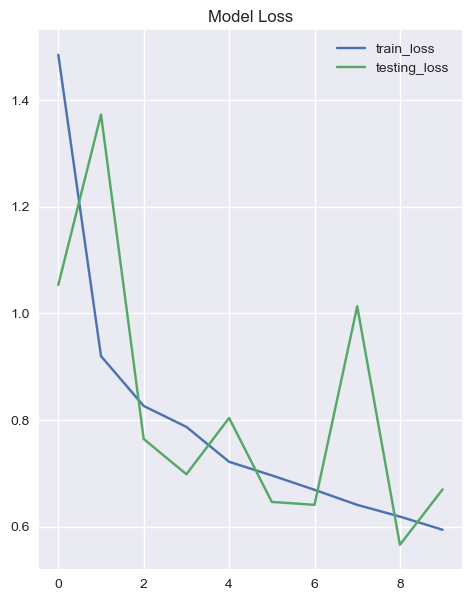

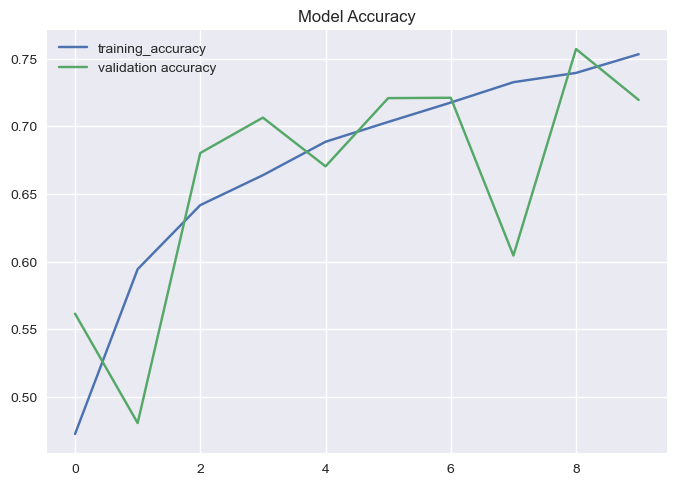

In [31]:
plt.style.use('seaborn')
plt.figure(figsize=(12,7))

plt.subplot(1,2,1)

plt.plot(history.history['loss'],label = 'train_loss')
plt.plot(history.history['val_loss'], label = 'testing_loss')
plt.title('Model Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='training_accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.title('Model Accuracy')
plt.legend()
plt.show()

59/59 [==============================] - 458s 8s/step


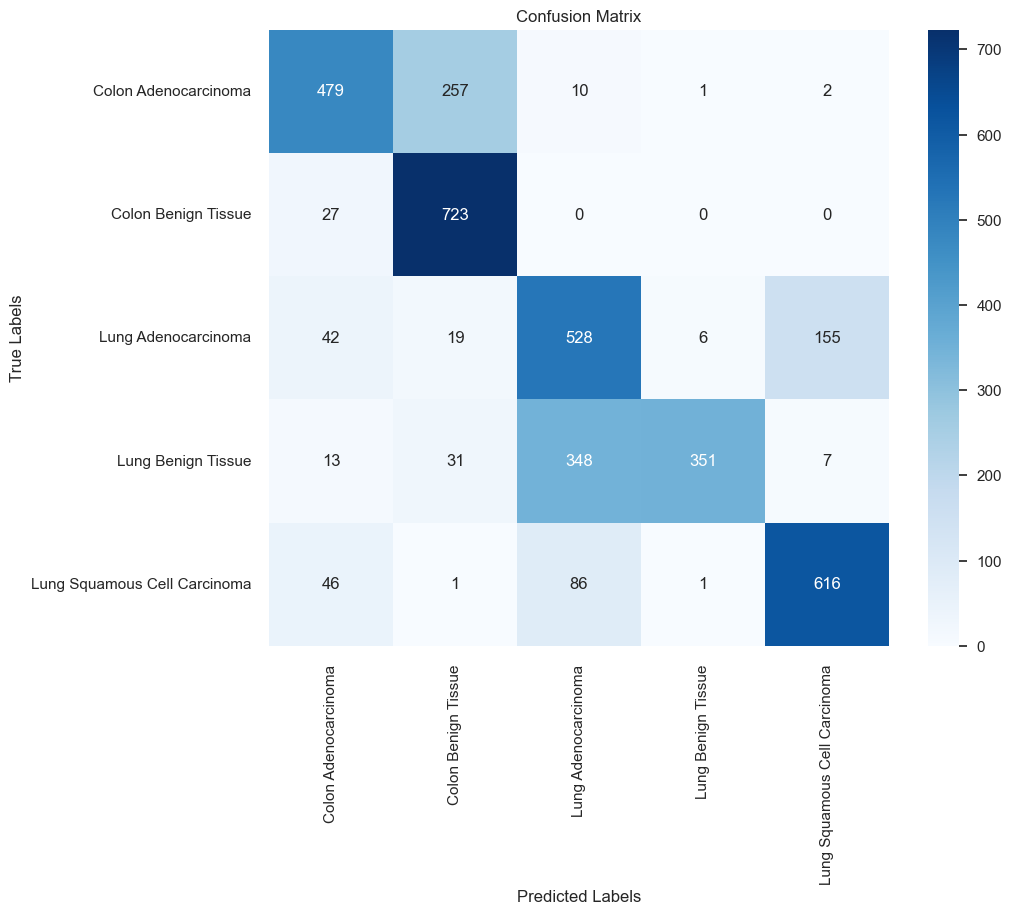

In [30]:
import numpy as np
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Predict labels using the trained model on the test set
y_pred_prob = resmodel.predict(test_gen)
y_pred = np.argmax(y_pred_prob, axis=1)

# Get true labels
true_labels = test_gen.classes

# Create confusion matrix
cm = confusion_matrix(true_labels, y_pred)

# Get class indices and names
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Plotting the confusion matrix
plt.figure(figsize=(10, 8))
sns.set(style='whitegrid')
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()